# Проект: Принятие решений в бизнесе

**Описание проекта:**                                                                                             

В крупном интернет-магазине подготовлен список гипотез для увеличения выручки.
Нужно приоритизовать гипотезы, запустить A/B-тест и проанализировать результаты.

В распоряжении:

- файл **/datasets/hypothesis.csv** - 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами **Reach, Impact, Confidence, Effort**.

- Результаты A/B-теста описаны в файлах **/datasets/orders.csv** и **/datasets/visitors.csv**.

Цель исследования:

Выяснить какая из гипотез приведет к наибольшему увеличению выручки.

Ход исследования:

Данные в:

- /datasets/hypothesis.csv
- /datasets/orders.csv
- /datasets/visitors.csv

Перед проверкой гипотез необходимо сделать обзор данных.
Проверим данные на ошибки и оценим их влияние на исследование. Исправим ошибки данных.

Этапы исследования:

- Загрузка данных и подготовка их к анализу.

- Приоритизация гипотез.

- Анализ A/B-теста.

# 1.Загрузка данных и подготовка их к анализу

Импортируем необходимые библиотеки, загрузим данные в переменные:

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime as dt
from datetime import datetime, timedelta
import seaborn as sns
from scipy import stats
pd.options.display.max_colwidth = 1

In [2]:
# загрузка данных
try:
    hypothesis = pd.read_csv('C:/Users/Александр/Desktop/yandex_project/hypothesis.csv')
    orders = pd.read_csv('C:/Users/Александр/Desktop/yandex_project/orders.csv')
    visitors = pd.read_csv('C:/Users/Александр/Desktop/yandex_project/visitors.csv')

except FileNotFoundError:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')

- Предобработка таблицы **hypothesis** - гипотезы:

In [3]:
hypothesis.info()
print("Кол-во дубликатов =",orders.duplicated().sum())
hypothesis.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
Кол-во дубликатов = 0


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
# приведем к нижнему регистру названия столбцов
hypothesis.columns = map(str.lower, hypothesis.columns)

In [5]:
# проверим названия столбцов
hypothesis.columns.to_list()

['hypothesis', 'reach', 'impact', 'confidence', 'efforts']

Данные корректные, типы правильные, дубликатов нет, привели к нижнему регистру названия столбцов, таблица готова к анализу.

- Предобработка таблицы **orders** - заказы:

In [6]:
# файл orders
orders['date'] = orders['date'].astype('datetime64[D]')
orders['date'] = orders['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
print('\nНачальная дата {}, конечная дата {}\n'.format(orders['date'].min(), orders['date'].max()))
print("Кол-во дубликатов =",orders.duplicated().sum())
# поменяем тип столбца "date" на datetime
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders.info()
orders.head(10)


Начальная дата 2019-08-01, конечная дата 2019-08-31

Кол-во дубликатов = 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


Все данные корректны, целостны, дубликатов нет, готовы к анализу. В процессе предобработки был поменян только тип столбца "date" на datetime.

In [7]:
# проверим, есть ли пользователи, оказавшиеся одновременно в двух группах
duplicat_users = np.intersect1d(orders.query('group == "A"')['visitorId'].unique(), orders.query('group == "B"')['visitorId'].unique())
display(duplicat_users)
# сосчитаем сколько их
len(duplicat_users)

array([   8300375,  199603092,  232979603,  237748145,  276558944,
        351125977,  393266494,  457167155,  471551937,  477780734,
        818047933,  963407295, 1230306981, 1294878855, 1316129916,
       1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
       1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
       2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
       2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
       2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
       3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
       3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
       3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
       4186807279, 4256040402, 4266935830])

58

Пользователей, оказавшихся одновременно в двух группах - 58. Такое незначительное количество ни на что не повлияет при АВ тестировании, поэтому оставим как есть.

- Предобработка таблицы **visitors** - посетители:

In [8]:
# файл visitors
visitors['date'] = visitors['date'].astype('datetime64[D]')
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
print('\nНачальная дата {}, конечная дата {}\n'.format(visitors['date'].min(), visitors['date'].max()))
# поменяем тип столбца "date" на datetime
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
print("Кол-во дубликатов =",visitors.duplicated().sum())
visitors.info()
visitors.head(10)


Начальная дата 2019-08-01, конечная дата 2019-08-31

Кол-во дубликатов = 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


Все данные корректны, целостны, дубликатов нет, готовы к анализу. В процессе предобработки был поменян только тип столбца "date" на datetime.

**Вывод:**

Данные прочитали, изменили тип данных у столбцов с датами, выгрузка совершена корректно, даты совпадают. Можно приступать к анализу.


# 2.Приоритизация гипотез

- Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.
- Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.
- Укажем, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясним, почему так произошло.

In [9]:
# посчитаем ICE для гипотез
hypothesis['ICE'] = (( hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(2)
hypothesis.sort_values(by='ICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


В первых местах гипотезы с индексами 8, 0, 7.

In [10]:
# посчитаем RICE для гипотез
hypothesis['RICE'] = (hypothesis['reach'] *  hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'].round(2)
hypothesis.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


В первых местах гипотезы с индексами 7, 2, 0.

**Вывод по приоритезации гипотез:**

Хорошо видно различие в обеих таблицах. Меняются первые места, в ICE это гипотезы с индексами 8, 0, 7, а в RICE - 7, 2, 0. Гипотеза под индексом 8 в таблице ICE сместилась на пятое место, а гипотеза под индексом 2 с пятого места сместилась на второе место. Мы говорим о том, что в фреймворке RICE мы учитываем важный параметр, как Reach (скольких пользователей затронет изменение, которое мы хотим внести), в этих гипотезах 7 и 2 Reach самый высокий. В гипотезе с индексом 7 равен 10 это самый максимальный,а во 2 равен 8 это тоже высокий. В ICE на первом месте гипотеза под индексом 8 и в ней Reach равен 1, это самый минимум. Параметр Reach, использующийся в методе RICE изменил всю приоритетность, полученную по методу ICE. Для тестирования выдвинем гипотезы под индексами 7 и 2.

# 3. Анализ A/B-теста

Для начала перед объединением данных сравним идентичны ли даты и группы в таблицах посетителей и заказов:

In [11]:
comparison = orders[['date','group']].drop_duplicates().sort_values(by=['date','group']).reset_index(drop=True) == \
                        visitors[['date','group']].drop_duplicates().sort_values(by=['date','group']).reset_index(drop=True)
print(comparison)

    date  group
0   True  True 
1   True  True 
2   True  True 
3   True  True 
4   True  True 
..   ...   ... 
57  True  True 
58  True  True 
59  True  True 
60  True  True 
61  True  True 

[62 rows x 2 columns]


In [12]:
print(comparison['date'].sum() ,comparison['group'].sum())

62 62


Данные в таблицах идентичны, поэтому таблицы можно объединять без проблем.

Объединим две таблицы в одну таблицу **cumulative**:

In [13]:
# удалим дубликаты
duplicat = orders[['date','group']].drop_duplicates()

aggregated_orders = duplicat.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]. \
                                    agg({'date' : 'max', 
                                         'group' : 'max', 
                                         'transactionId' : pd.Series.nunique, 
                                         'visitorId' : pd.Series.nunique, 
                                         'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

aggregated_visitors = duplicat.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]. \
                                    agg({'date' : 'max', 
                                         'group' : 'max', 
                                         'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

cumulative = aggregated_orders.merge(aggregated_visitors, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative.head(10)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
5,2019-08-03,B,61,59,380996,1803
6,2019-08-04,A,84,77,425699,2562
7,2019-08-04,B,78,75,489567,2573
8,2019-08-05,A,109,100,549917,3318
9,2019-08-05,B,101,98,581995,3280


- Построим график кумулятивной выручки по группам:

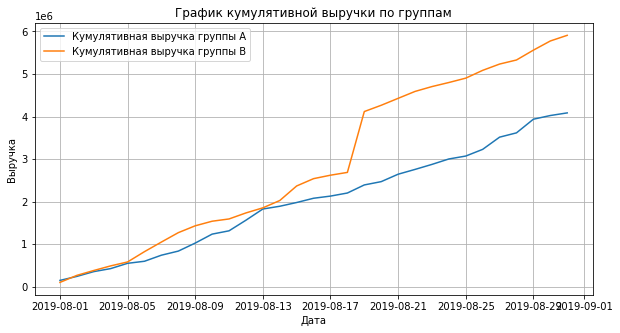

In [14]:
cumulative_A = cumulative[cumulative['group']=='A'][['date','revenue', 'orders']]
cumulative_B = cumulative[cumulative['group']=='B'][['date','revenue', 'orders']]
# строим графики
plt.figure(figsize=(10,5))
plt.plot(cumulative_A['date'], cumulative_A['revenue'], label='Кумулятивная выручка группы A')
plt.plot(cumulative_B['date'], cumulative_B['revenue'], label='Кумулятивная выручка группы B')
plt.title('График кумулятивной выручки по группам')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.legend()
plt.grid()

На графике видно, что в первой половине месяца видно как выручка в группе B растёт быстрее, чем в A. 13.08.2019 выручки примерно одинаковы. Затем 18.08.2019 наблюдается сильный скачок по выручке в группе B, скорее всего это могло произойти из-за крупного заказа, результатом которого разрыв между группами стал еще более значительным, далее обе линии идут параллельно.
Группа B стабильно показывает большую выручку, чем группа A.

- Построим график кумулятивного среднего чека по группам, разделим кумулятивную выручку на кумулятивное число заказов.:

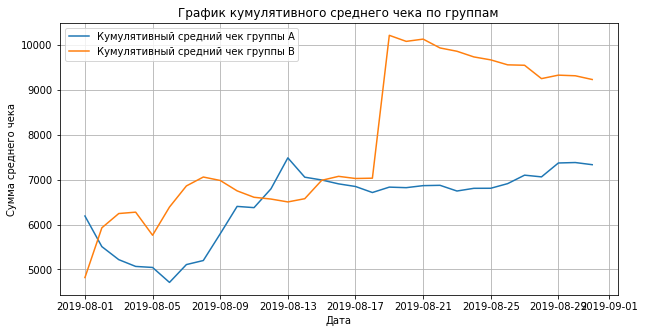

In [15]:
plt.figure(figsize=(10,5))
plt.plot(cumulative_A['date'], cumulative_A['revenue']/cumulative_A['orders'], label='Кумулятивный средний чек группы A')
plt.plot(cumulative_B['date'], cumulative_B['revenue']/cumulative_B['orders'], label='Кумулятивный средний чек группы B')
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel('Сумма среднего чека')
plt.xlabel('Дата')
plt.legend()
plt.grid()

На графике видно, что в начале месяца средний чек в группе B больше. Средний чек группы А имеет наибольшую выручку это 1.08.2019 и с 12.08.2019 по 14.08.2019. Далее в остальном средний чек группы B стабильно больше. На этом графике заметна роль крупного заказа 18.08.2019 и после него заметно постепенное снижение среднего чека нруппы В, а средний чек группы А начал постепенно расти.

- Построим график относительного изменения кумулятивного среднего чека группы B к группе A:

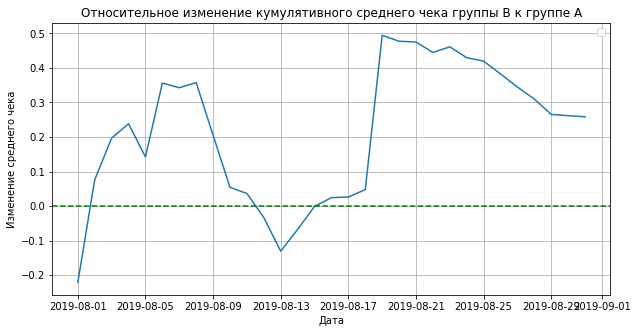

In [16]:
# соберём данные в один датафрейм
connected_cumulative = cumulative_A.merge(cumulative_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
# строим график
plt.figure(figsize=(10,5))
plt.plot(connected_cumulative['date'], (connected_cumulative['revenueB']/connected_cumulative['ordersB'])/ \
         (connected_cumulative['revenueA']/connected_cumulative['ordersA'])-1)
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе А')
plt.axhline(y=0, color='green', linestyle='--')
plt.ylabel('Изменение среднего чека')
plt.xlabel('Дата')
plt.legend('')
plt.grid()

На графикке видно относительное различие в среднем чеке между группами, наблюдается сильное изменеие значений в определённые даты. По вероятности тогда был совершен крупный заказ.
Кумулятивная выручка группы В выше, чем у группы А, но она нестабильна. Возможно дело в выбросах с обоих сторон.

- Построим график кумулятивного среднего количества заказов на посетителя по группам:

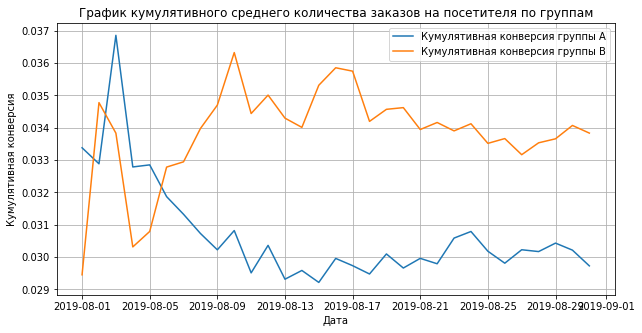

In [17]:
# считаем кумулятивную конверсию
cumulative['conversion'] = cumulative['orders']/cumulative['visitors']
# отделяем данные по группе A
cumulative_A = cumulative[cumulative['group']=='A']
# отделяем данные по группе B
cumulative_B = cumulative[cumulative['group']=='B']
# строим графики
plt.figure(figsize=(10,5))
plt.plot(cumulative_A['date'], cumulative_A['conversion'], label='Кумулятивная конверсия группы A')
plt.plot(cumulative_B['date'], cumulative_B['conversion'], label='Кумулятивная конверсия группы B')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.ylabel('Кумулятивная конверсия')
plt.xlabel('Дата')
plt.legend()
plt.grid()

На графике видно, что группы стартовали с очень разных значений. Конверсия группы А с начала месяца была значительно больше, 3.08.2019 был максимум за весь период, затем группа A постепенно снизилась. Группа B с 4.08.2019 начала расти, с 6.08.2019 начала подниматься, превысив группу А и затем стабилизировалась. Группа B стабильно показывает большую конверсию чем группа A.

- Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A:

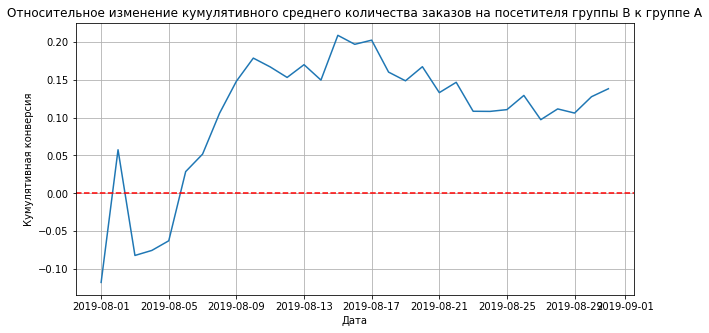

In [18]:
cumulative_conversions = cumulative_A[['date','conversion']].merge(cumulative_B[['date','conversion']], \
                                                    left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(cumulative_conversions['date'], cumulative_conversions['conversionB']/cumulative_conversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.axhline(y=0, color='red', linestyle='--')

График различия конверсии между группами сообщает, что результаты группы B стабильно лучше группы A и есть некоторая общая тенденция к его ухудшению.
Конверсия в группе B стабильно лучше конверсии в группе A на 10% по просшествии 1 недели после начала.

- Построим точечный график количества заказов по пользователям:

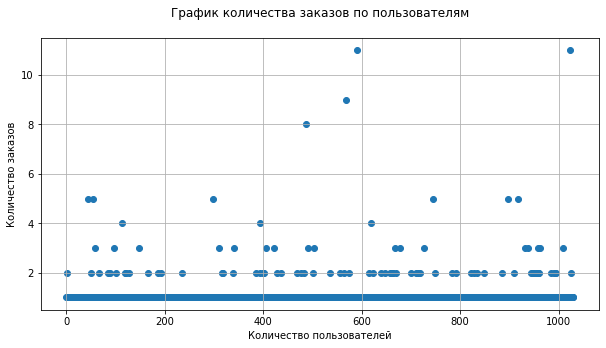

In [19]:
users_orders = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False). \
                                                                        agg({'transactionId' : pd.Series.nunique})

users_orders.columns = ['user_id','orders']
users_orders.sort_values(by='orders',ascending=False)

plt.figure(figsize=(10,5))
plt.grid()
plt.title('График количества заказов по пользователям\n  ')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')
values = pd.Series(range(0, len(users_orders)))
plt.scatter(values, users_orders['orders'])

На графике видно, что больше всего пользователей, которые совершили 1 заказ. Которые совершили больше одного заказа возможно будут являться выбросами, что  стоит посчитать выборочные перцентили.

- Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберим границу для определения аномальных пользователей:

In [20]:
percentiles = np.percentile(users_orders['orders'], [95, 99])
print('Перцентили количества заказов на пользователя:\n95: {}\n99: {}'.format(percentiles[0],percentiles[1]))

Перцентили количества заказов на пользователя:
95: 2.0
99: 4.0


Два и больше двух заказов совершают только 5% пользователей, а четыре и больше четырёх всего 1%.

- Построим точечный график стоимостей заказов:

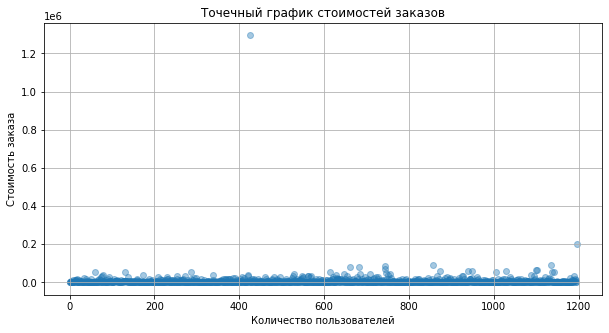

In [21]:
values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(10,5))
plt.grid()
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказа')
plt.scatter(values, orders['revenue'], alpha=0.4)
#plt.ylim([0,150000])

На графике виден один самый крупный заказ на сумму больше 1 млн и ещё один заказ в размере 200 тысяч.Все остальные заказы ниже 100 тысяч. Чтобы точно определить стоимость аномальных заказов необходимо посчитать выборочные перцентели.

- Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберим границу для определения аномальных заказов:

In [22]:
percentiles = np.percentile(orders['revenue'], [95, 99])
print('Перцентили стоимости заказов:\n95: {:.0f}\n99: {:.0f}'.format(percentiles[0],percentiles[1]))

Перцентили стоимости заказов:
95: 28000
99: 58233


Как видно 5% пользователей совершают покупки до 28 тысяч рублей, всего 1% пользователей совершают покупки до 58 223 тысяч рублей.

- Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным:

**Сформулируем гипотезы:**

- Н0 : По неочищенным данным различий в конверсии групп A и B не имеется
- Н1 : По неочищенным данным в конверсии групп A и B разница статистически значима

Для тестирования воспользуемся критерием Манна-Уитни, уровнем статистической значимости примем значение 0,05

In [23]:
users_orders_A = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
users_orders_A.columns = ['visitorId', 'orders']
users_orders_B = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
users_orders_B.columns = ['visitorId', 'orders']
print('Количество покупателей в группе A: {}'.format(len(users_orders_A)))
print('Количество покупок в группе А: {}'.format(users_orders_A['orders'].sum()))
print('Количество посетителей в группе A: {}\n'.format(visitors[visitors['group']=='A']['visitors'].sum()))
print('Количество покупателей в группе B: {}'.format(len(users_orders_B)))
print('Количество покупок в группе B: {}'.format(users_orders_B['orders'].sum()))
print('Количество посетителей в группе B: {}'.format(visitors[visitors['group']=='B']['visitors'].sum()))
# составим списки количества заказов со всеми пользователями по группам и так же которые не купили  
orders_list_1 =[]
for i in range(0,(visitors[visitors['group']=='A']['visitors'].sum()-len(users_orders_A))):
    orders_list_1.append(0)
orders_not_bought_A = pd.Series(data = orders_list_1, name = 'orders')

orders_list_2 =[]
for i in range(0,(visitors[visitors['group']=='B']['visitors'].sum()-len(users_orders_B))):
    orders_list_2.append(0)
orders_not_bought_B = pd.Series(data = orders_list_2, name = 'orders')

orders_A = pd.concat([users_orders_A['orders'], orders_not_bought_A], axis=0)
orders_B = pd.concat([users_orders_B['orders'], orders_not_bought_B], axis=0)
# расчитаем относительный прирост конверсии группы В по отношению к группе A
print('Относительный прирост конверсии группы B по отношению к группе A: {0:.3f}'.format(orders_B.mean()/orders_A.mean()-1))
# для тестирования воспользуемся критерием Манна-Уитни, уровнем статистической значимости примем значение 0,05
alpha = 0.05
results = stats.mannwhitneyu(orders_A, orders_B)
print('P-value критерия Манна-Уитни: {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('По неочищенным данным в конверсии групп A и B разница статистически значима')
else:
    print('По неочищенным данным различий в конверсии групп A и B не имеется')

Количество покупателей в группе A: 503
Количество покупок в группе А: 557
Количество посетителей в группе A: 18736

Количество покупателей в группе B: 586
Количество покупок в группе B: 640
Количество посетителей в группе B: 18916
Относительный прирост конверсии группы B по отношению к группе A: 0.138
P-value критерия Манна-Уитни: 0.017
По неочищенным данным в конверсии групп A и B разница статистически значима


Как видим статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным равна 0.017, это меньше уровня статистической значимости, поэтому гипотезу отвергаем, которая говорит о том, что различий в конверсии между группами нет. Относительный прирост конверсии группы B больше на 13,8 % , чем в группе А.

- Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным:

**Сформулируем гипотезы:**

- Н0 : По неочищенным данным различия в средних чеках заказа между группами A и B нет
- Н1 : По неочищенным данным различие в среднем чеке заказа между группами A и B статистически значимо

Для тестирования воспользуемся критерием Манна-Уитни, уровнем статистической значимости примем значение 0,05

In [24]:
# расчитаем относительные различия суммы среднего чека
print('Относительное изменение среднего чека в группе B по отношению группы A: {0:.3f}'.format(
orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))
# для тестирования так же воспользуемся критерием Манна-Уитни, уровнем статистической значимости примем значение 0,05
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
print('P-value: {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('По неочищенным данным различие в среднем чеке заказа между группами A и B статистически значимо')
else:
    print('По неочищенным данным различия в средних чеках заказа между группами A и B нет')

Относительное изменение среднего чека в группе B по отношению группы A: 0.259
P-value: 0.729
По неочищенным данным различия в средних чеках заказа между группами A и B нет


Как видим статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным равна 0.729, это больше уровня статистической значимости, поэтому гипотезу не отвергаем. Средние чеки между группами схожи. Относительное изменение среднего чека в группе B по отношению группы A равно 26%.

- Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным:

Как мы определились ранее, что за аномальных пользователей примем тех, кто совершил более 1 заказа или совершили заказ дороже 58 233 рублей. Необходимо сделать срезы пользователей с числом заказов больше 1 и  пользователей, совершивших заказы дороже 58 233. Создадим общую таблицу и узнаем, сколько всего аномальных пользователей.

Зададим предельные количество заказов и сумму покупки для создания списка аномальных пользователей с помощью перцентилей:

In [25]:
revenue_limit = int(np.percentile(orders['revenue'], [95]))
revenue_limit

28000

In [26]:
orders_limit = int(np.percentile(users_orders['orders'], [95]))
orders_limit

2

In [27]:
users_commit_orders = pd.concat([users_orders_A[users_orders_A['orders']>orders_limit]['visitorId'], 
                                users_orders_B[users_orders_B['orders']>orders_limit]['visitorId']], axis = 0)
users_expensive_orders = orders[orders['revenue']>revenue_limit]['visitorId']
abnormal_users = pd.concat([users_commit_orders, users_expensive_orders], axis = 0).drop_duplicates().sort_values()
print('Количество аномальных пользователей: {}'.format(len(abnormal_users)))

Количество аномальных пользователей: 74


Теперь проверим как 74 аномальных пользователей повлияли на результат теста. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [28]:
definite_users_A = pd.concat([
    users_orders_A[np.logical_not(users_orders_A['visitorId'].isin(abnormal_users))]['orders'],
    orders_not_bought_A
], axis = 0)
definite_users_B = pd.concat([
    users_orders_B[np.logical_not(users_orders_B['visitorId'].isin(abnormal_users))]['orders'],
    orders_not_bought_B
], axis = 0)
print('Относительный прирост конверсии группы B по отношению к группе A после очистки данных: {0:.3f}'.format(definite_users_B.mean()/definite_users_A.mean()-1))
results = stats.mannwhitneyu(definite_users_A, definite_users_B)
print('P-value: {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('По очищенным данным в конверсии групп A и B разница статистически значима')
else:
    print('По очищенным данным различий в конверсии групп A и B нет')

Относительный прирост конверсии группы B по отношению к группе A после очистки данных: 0.173
P-value: 0.013
По очищенным данным в конверсии групп A и B разница статистически значима


Как видим статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным равна 0.013, это меньше уровня статистической значимости, поэтому гипотезу отвергаем. Относительный прирост конверсии группы B по отношению к группе A после очистки данных равен 17%. Это больше чем 13,8% по «сырым» данным.

- Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным:

In [29]:
print('Относительное изменение среднего чека в группе B по отношению группы A после очистки данных: {0:.3f}'.format(
orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'].mean()\
/orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'].mean()-1))
       
       
results = stats.mannwhitneyu(orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'],
                             orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(abnormal_users)))]['revenue'])
print('P-value: {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('По очищенным данным разница в средних чеках в группах A и B статистически значима')
else:
    print('По очищенным данным различий в средних чеках в группах A и B нет')

Относительное изменение среднего чека в группе B по отношению группы A после очистки данных: -0.020
P-value: 0.738
По очищенным данным различий в средних чеках в группах A и B нет


Как видим статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным равна 0.738, это больше заданного уровня статистической значимости, поэтому гипотезу не отвергаем. Средние чеки между группами схожи. Относительное изменение среднего чека в группе B по отношению группы A равно 2%, а по «сырым» данным было 26%. Это всё по причине того самого крупного заказ на сумму больше 1 млн.

- решение по результатам теста:

Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

**Вывод:**                                                                                                                     

Как увидели по результатам тестирования по "сырым" и по "очищенным" данным различия в конверсии групп A и B есть. Относительный выигрыш группы B над A равен 17% по "очищенным" и 13.8% по "сырым" данным.
Различия по "сырым" и по "очищенным" данным в средних чеках групп A и B отстутствуют, несмотря на то, что средний чек группы B оказался незначительно (на 2%) ниже среднего чека группы A по "очищенным" данным, а по "сырым" данным, он был 26%, по причине того самого крупного заказ на сумму больше 1 млн. Аномальный заказ убрали и чеки сравнялись. Из вариантов решений я останавливаюсь на первом варианте, это остановить тест, зафиксировать победу группы B, она значительно лучше, чем A в части конверсии.

**Общий вывод:**

RICE и ICE - два фреймворка для приоритизации гипотез. В RICE учитывается параметр Reach, в ICE - нет. При использовании обоих фреймворков, гипотезы могут менять свою приоритетность в зависимости от учета параметра Reach. В данном случае, гипотезы под индексами 7 и 2 имеют самый высокий параметр Reach в RICE, поэтому они приоритетнее, чем в ICE.
По результатам тестирования обнаружены различия в конверсии между группами A и B, но различий в средних чеках нет. Причина различий в средних чеках была связана с крупным заказом, который был убран из данных. Остановка теста и зафиксирование победы группы B является рекомендуемым вариантом, так как она значительно лучше группы A в части конверсии.
